# Logistic Regression on Breast Cancer Dataset

This notebook implements Logistic Regression classifier on the breast cancer dataset and visualizes the results with various plots and performance metrics.

In [9]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, roc_curve, auc, 
                           precision_recall_curve, roc_auc_score)
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Load and Explore the Dataset

In [10]:
# Load the breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Create DataFrame for better visualization
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

print("Dataset Information:")
print(f"Shape: {df.shape}")
print(f"Features: {len(data.feature_names)}")
print(f"Classes: {data.target_names}")
print(f"Class distribution:")
print(pd.Series(y).value_counts().sort_index())

# Display basic statistics
print("\nBasic Statistics:")
print(df.describe())

Dataset Information:
Shape: (569, 31)
Features: 30
Classes: ['malignant' 'benign']
Class distribution:
0    212
1    357
Name: count, dtype: int64

Basic Statistics:
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std  

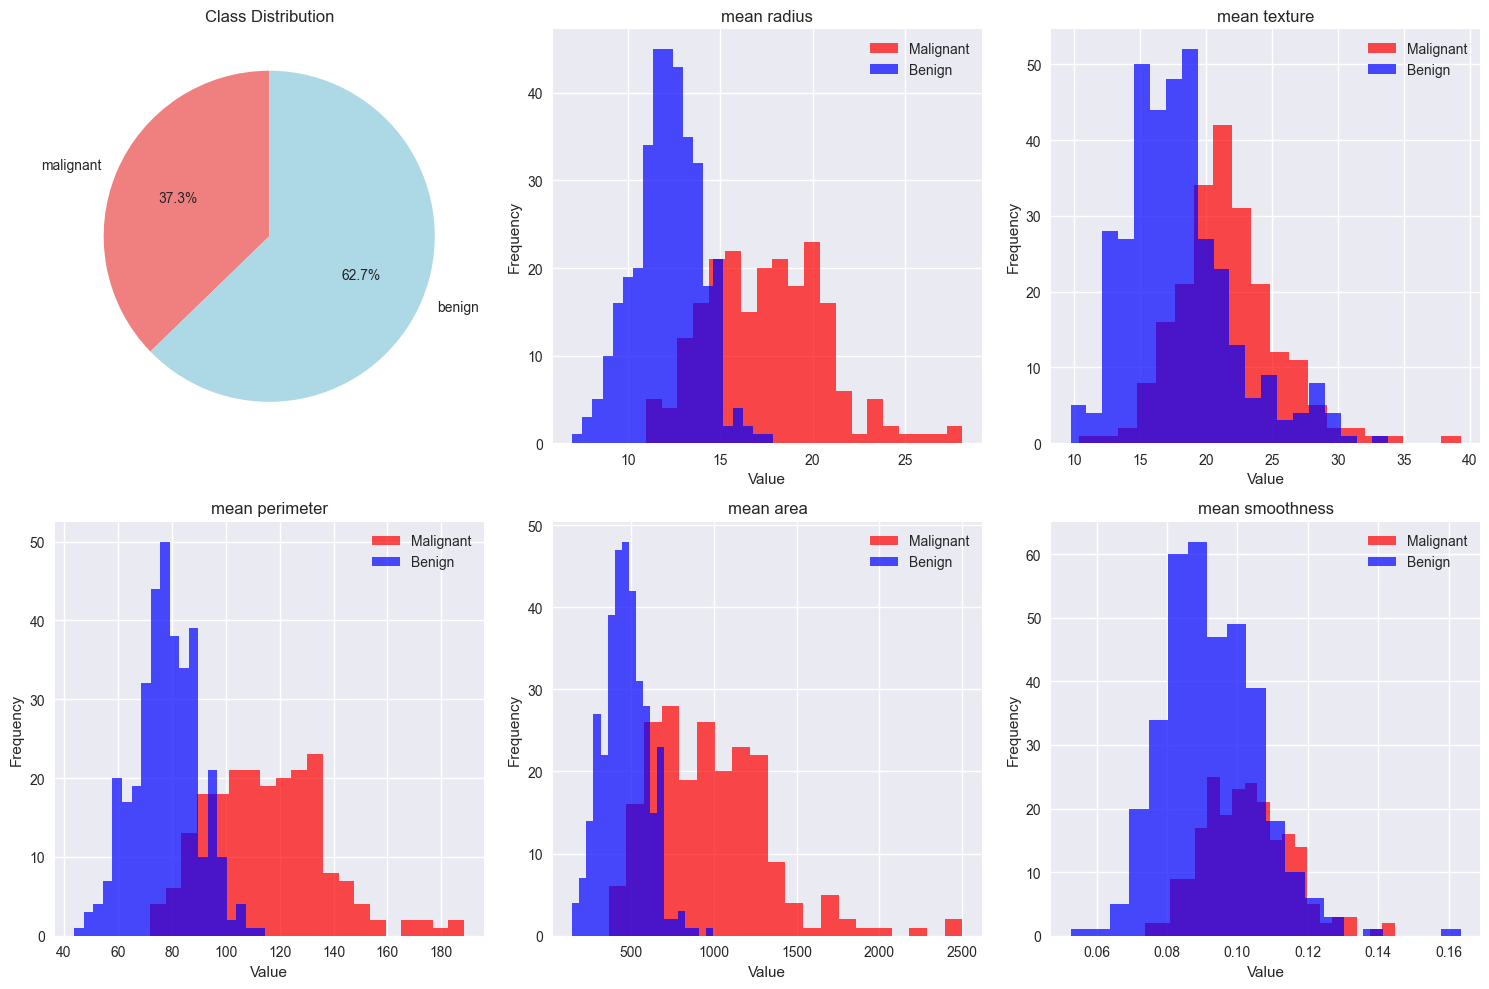

Malignant (0): 212 samples (37.3%)
Benign (1): 357 samples (62.7%)


In [11]:
# Visualize class distribution and key features
plt.figure(figsize=(15, 10))

# Class distribution
plt.subplot(2, 3, 1)
class_counts = pd.Series(y).value_counts().sort_index()
colors = ['lightcoral', 'lightblue']
plt.pie(class_counts.values, labels=data.target_names, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Class Distribution')

# Feature distributions for key features
key_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']

for i, feature in enumerate(key_features, 2):
    plt.subplot(2, 3, i)
    
    # Get feature index
    feature_idx = list(data.feature_names).index(feature)
    
    # Plot distributions for each class
    malignant_data = X[y == 0, feature_idx]
    benign_data = X[y == 1, feature_idx]
    
    plt.hist(malignant_data, alpha=0.7, label='Malignant', bins=20, color='red')
    plt.hist(benign_data, alpha=0.7, label='Benign', bins=20, color='blue')
    
    plt.title(f'{feature}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

print(f"Malignant (0): {class_counts[0]} samples ({class_counts[0]/len(y)*100:.1f}%)")
print(f"Benign (1): {class_counts[1]} samples ({class_counts[1]/len(y)*100:.1f}%)")

## 2. Data Preprocessing

In [12]:
# Check for missing values and data types
print("Missing values per column:")
print(pd.DataFrame(X, columns=data.feature_names).isnull().sum().sum())
print("\nData types:")
print(pd.DataFrame(X, columns=data.feature_names).dtypes.value_counts())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nOriginal data shape: {X.shape}")
print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# Check scaling effect
print(f"\nBefore scaling - Mean: {X_train.mean():.3f}, Std: {X_train.std():.3f}")
print(f"After scaling - Mean: {X_train_scaled.mean():.3f}, Std: {X_train_scaled.std():.3f}")

Missing values per column:
0

Data types:
float64    30
Name: count, dtype: int64

Original data shape: (569, 30)
Training set: (455, 30)
Test set: (114, 30)
Training class distribution: [170 285]
Test class distribution: [42 72]

Before scaling - Mean: 61.214, Std: 224.610
After scaling - Mean: -0.000, Std: 1.000


## 3. Correlation Analysis

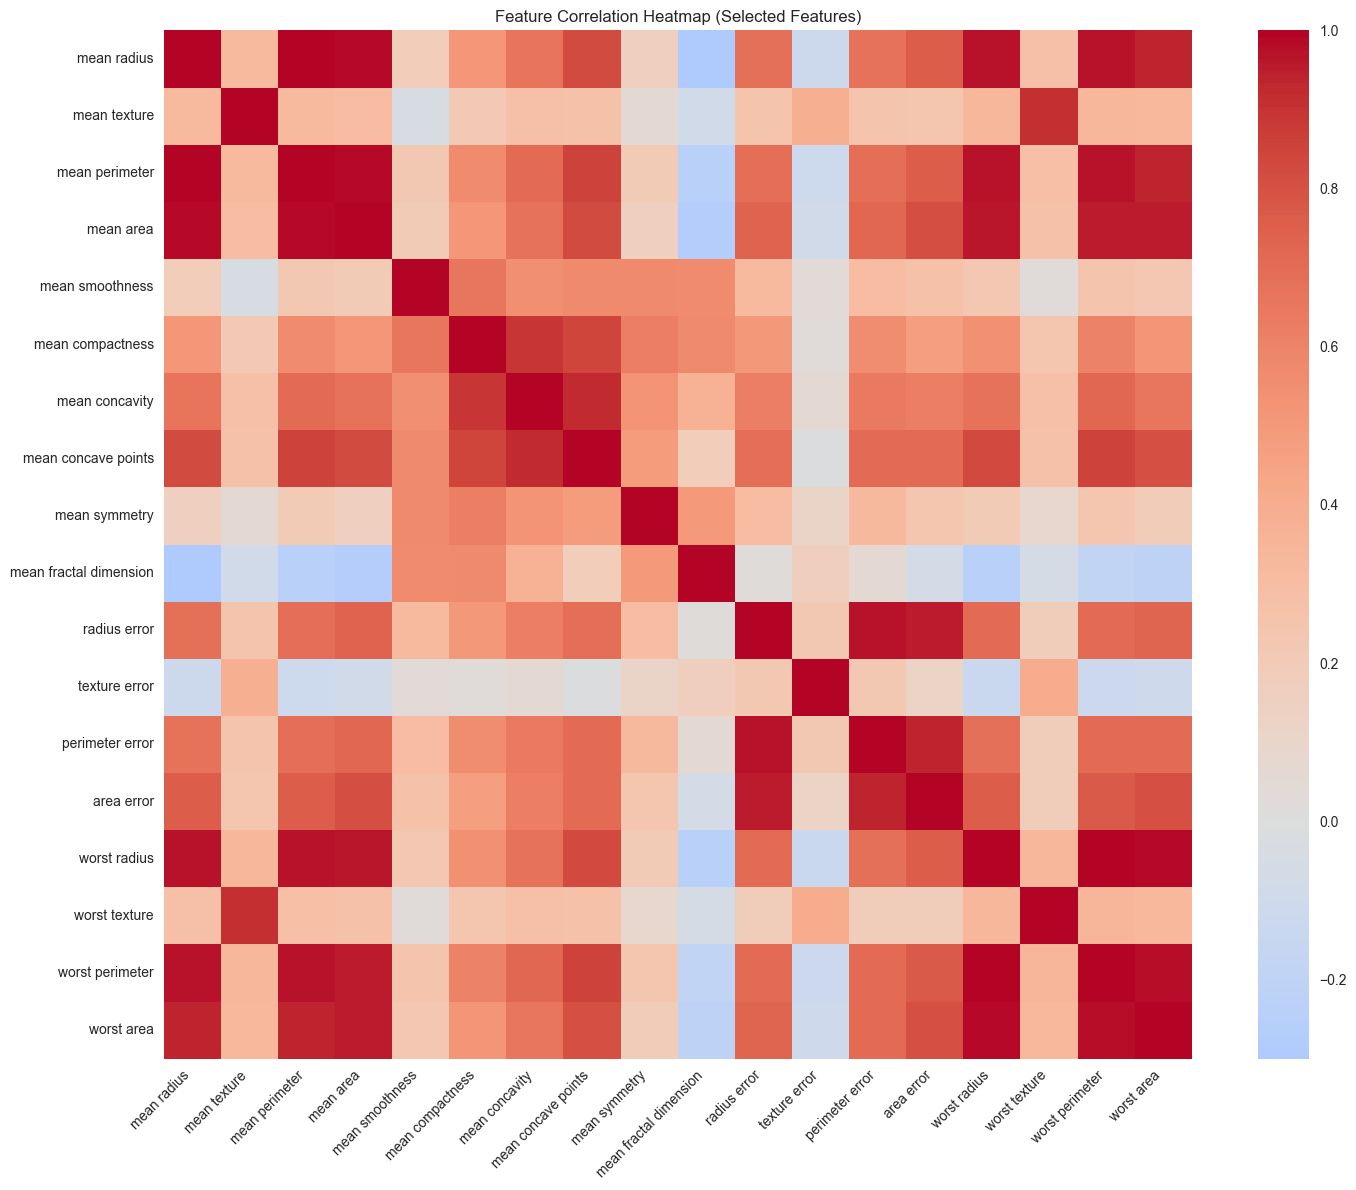

Highly correlated feature pairs (|correlation| > 0.8):
mean radius - mean perimeter: 0.998
worst radius - worst perimeter: 0.993
mean radius - mean area: 0.989
mean perimeter - mean area: 0.988
worst radius - worst area: 0.986
worst perimeter - worst area: 0.979
mean perimeter - worst perimeter: 0.971
radius error - perimeter error: 0.971
mean radius - worst radius: 0.970
mean perimeter - worst radius: 0.970
mean radius - worst perimeter: 0.966
mean area - worst radius: 0.963
mean area - worst perimeter: 0.959
mean area - worst area: 0.957
radius error - area error: 0.955
mean radius - worst area: 0.943
mean perimeter - worst area: 0.943
perimeter error - area error: 0.939
mean concavity - mean concave points: 0.922
mean texture - worst texture: 0.913
mean compactness - mean concavity: 0.896
mean concave points - worst perimeter: 0.857
mean perimeter - mean concave points: 0.852
mean compactness - mean concave points: 0.843
mean concave points - worst radius: 0.830
mean area - mean con

In [13]:
# Correlation analysis
plt.figure(figsize=(15, 12))

# Select subset of features for correlation analysis
selected_features = [
    'mean radius', 'mean texture', 'mean perimeter', 'mean area',
    'mean smoothness', 'mean compactness', 'mean concavity',
    'mean concave points', 'mean symmetry', 'mean fractal dimension',
    'radius error', 'texture error', 'perimeter error', 'area error',
    'worst radius', 'worst texture', 'worst perimeter', 'worst area'
]

# Get indices of selected features
selected_indices = [list(data.feature_names).index(feature) for feature in selected_features]

# Create correlation matrix
correlation_matrix = np.corrcoef(X_train_scaled[:, selected_indices].T)

# Plot heatmap
sns.heatmap(correlation_matrix, 
            xticklabels=selected_features,
            yticklabels=selected_features,
            annot=False, 
            cmap='coolwarm', 
            center=0,
            square=True)
plt.title('Feature Correlation Heatmap (Selected Features)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Find highly correlated feature pairs
correlation_df = pd.DataFrame(correlation_matrix, 
                            index=selected_features, 
                            columns=selected_features)

# Get upper triangle of correlation matrix
upper_triangle = correlation_df.where(
    np.triu(np.ones(correlation_df.shape), k=1).astype(bool)
)

# Find highly correlated pairs (> 0.8)
high_corr_pairs = []
for i in range(len(upper_triangle.columns)):
    for j in range(len(upper_triangle.columns)):
        if abs(upper_triangle.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                upper_triangle.index[i], 
                upper_triangle.columns[j], 
                upper_triangle.iloc[i, j]
            ))

print("Highly correlated feature pairs (|correlation| > 0.8):")
for feature1, feature2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
    print(f"{feature1} - {feature2}: {corr:.3f}")

## 4. Logistic Regression Implementation

In [14]:
# Create and train Logistic Regression model
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr.predict(X_test_scaled)
y_pred_proba = lr.predict_proba(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

# Cross-validation score
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

Logistic Regression Accuracy: 0.9825
Cross-validation scores: [0.96703297 0.97802198 0.96703297 1.         0.98901099]
Mean CV score: 0.9802 (+/- 0.0256)
ROC AUC Score: 0.9954


## 5. Hyperparameter Tuning

In [15]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Note: l1 penalty only works with liblinear and saga solvers
grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Train the best model
best_lr = grid_search.best_estimator_
y_pred_best = best_lr.predict(X_test_scaled)
y_pred_proba_best = best_lr.predict_proba(X_test_scaled)

accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best model test accuracy: {accuracy_best:.4f}")

# Compare models
print(f"\nModel Comparison:")
print(f"Default LR Accuracy: {accuracy:.4f}")
print(f"Tuned LR Accuracy: {accuracy_best:.4f}")
print(f"Improvement: {accuracy_best - accuracy:.4f}")

Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score: 0.9802197802197803
Best model test accuracy: 0.9737

Model Comparison:
Default LR Accuracy: 0.9825
Tuned LR Accuracy: 0.9737
Improvement: -0.0088


## 6. Model Evaluation and Visualization

In [16]:
# Classification Report
print("Classification Report (Best Model):")
print(classification_report(y_test, y_pred_best, target_names=data.target_names))

Classification Report (Best Model):
              precision    recall  f1-score   support

   malignant       0.98      0.95      0.96        42
      benign       0.97      0.99      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



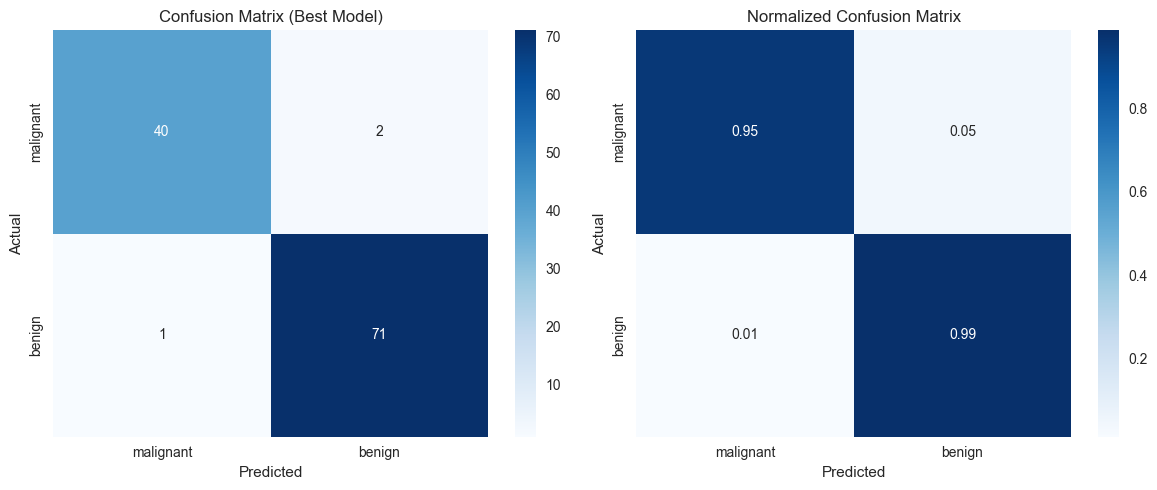

True Negatives: 40
False Positives: 2
False Negatives: 1
True Positives: 71
Sensitivity (Recall): 0.9861
Specificity: 0.9524
Precision: 0.9726
F1-Score: 0.9793


In [17]:
# Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=data.target_names, 
            yticklabels=data.target_names)
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
# Normalized confusion matrix
cm_normalized = confusion_matrix(y_test, y_pred_best, normalize='true')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=data.target_names, 
            yticklabels=data.target_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Calculate confusion matrix metrics
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Sensitivity (Recall): {tp/(tp+fn):.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")
print(f"Precision: {tp/(tp+fp):.4f}")
print(f"F1-Score: {2*tp/(2*tp+fp+fn):.4f}")

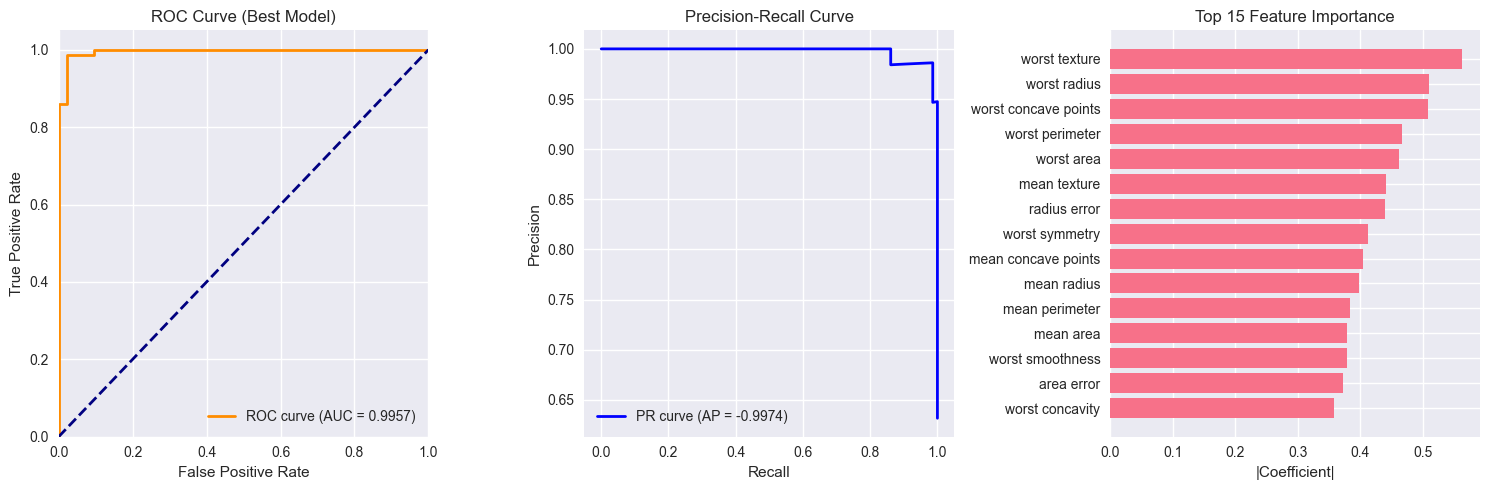

ROC AUC Score: 0.9957
Average Precision Score: -0.9974


In [18]:
# ROC Curve and Precision-Recall Curve
plt.figure(figsize=(15, 5))

# ROC Curve
plt.subplot(1, 3, 1)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best[:, 1])
roc_auc_best = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc_best:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Best Model)')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 3, 2)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_best[:, 1])
avg_precision = np.trapz(precision, recall)

plt.plot(recall, precision, color='blue', lw=2,
         label=f'PR curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Feature Importance (Coefficients)
plt.subplot(1, 3, 3)
feature_importance = abs(best_lr.coef_[0])
feature_names = data.feature_names

# Sort features by importance
sorted_idx = np.argsort(feature_importance)[-15:]  # Top 15 features
top_features = [feature_names[i] for i in sorted_idx]
top_importance = feature_importance[sorted_idx]

plt.barh(range(len(top_features)), top_importance)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('|Coefficient|')
plt.title('Top 15 Feature Importance')
plt.tight_layout()

plt.tight_layout()
plt.show()

print(f"ROC AUC Score: {roc_auc_best:.4f}")
print(f"Average Precision Score: {avg_precision:.4f}")

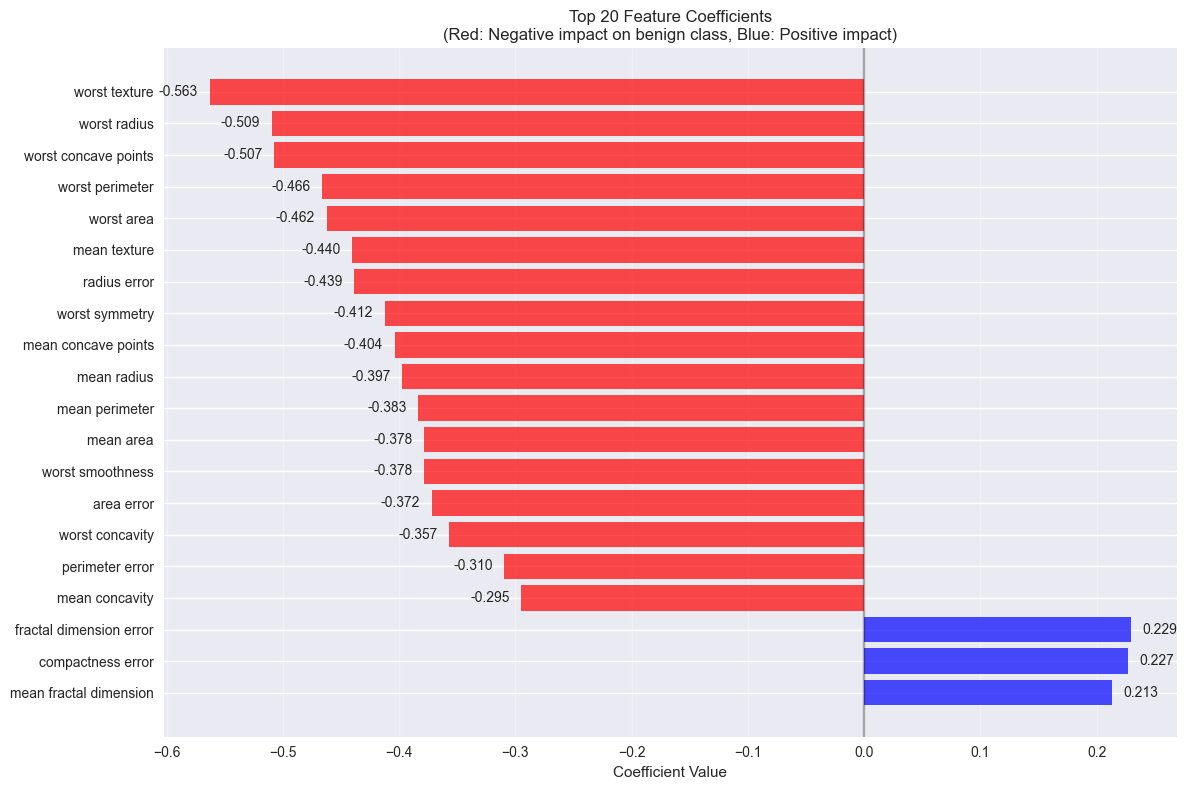

Top 10 Most Important Features:
                 feature  coefficient  abs_coefficient
0            mean radius    -0.397260         0.397260
7    mean concave points    -0.403951         0.403951
28        worst symmetry    -0.412164         0.412164
10          radius error    -0.438711         0.438711
1           mean texture    -0.440111         0.440111
23            worst area    -0.462260         0.462260
22       worst perimeter    -0.466214         0.466214
27  worst concave points    -0.507317         0.507317
20          worst radius    -0.509431         0.509431
21         worst texture    -0.562982         0.562982


In [19]:
# Detailed Feature Importance Analysis
plt.figure(figsize=(12, 8))

# Get all coefficients and feature names
coefficients = best_lr.coef_[0]
feature_names = data.feature_names

# Create a dataframe for easier handling
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=True)

# Plot top 20 features
top_20 = coef_df.tail(20)

colors = ['red' if x < 0 else 'blue' for x in top_20['coefficient']]
plt.barh(range(len(top_20)), top_20['coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Feature Coefficients\n(Red: Negative impact on benign class, Blue: Positive impact)')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_20.iterrows()):
    plt.text(row['coefficient'] + (0.01 if row['coefficient'] > 0 else -0.01), i, 
             f'{row["coefficient"]:.3f}', 
             va='center', ha='left' if row['coefficient'] > 0 else 'right')

plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(coef_df.tail(10)[['feature', 'coefficient', 'abs_coefficient']])

## 7. Decision Boundary Visualization using PCA

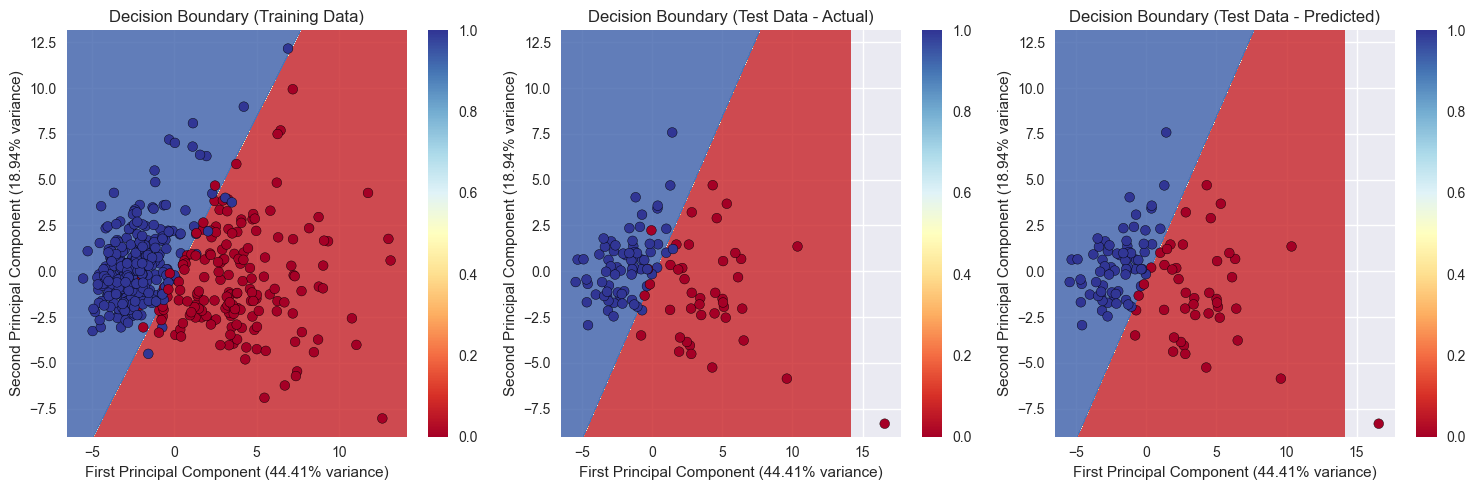

PCA Logistic Regression Accuracy: 0.9474
Explained variance ratio: [0.44413492 0.18944618]
Total explained variance: 0.6336


In [20]:
# Visualize decision boundary using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train logistic regression on PCA-reduced data
lr_pca = LogisticRegression(random_state=42, max_iter=1000)
lr_pca.fit(X_train_pca, y_train)

# Create a mesh for plotting decision boundary
h = 0.02  # step size in the mesh
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(15, 5))

# Plot decision boundary
plt.subplot(1, 3, 1)
Z = lr_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, 
                     cmap=plt.cm.RdYlBu, edgecolors='black')
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Decision Boundary (Training Data)')
plt.colorbar(scatter)

# Plot test data predictions
plt.subplot(1, 3, 2)
y_pred_pca = lr_pca.predict(X_test_pca)
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, 
                     cmap=plt.cm.RdYlBu, edgecolors='black')
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Decision Boundary (Test Data - Actual)')
plt.colorbar(scatter)

# Plot test data with predictions
plt.subplot(1, 3, 3)
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred_pca, 
                     cmap=plt.cm.RdYlBu, edgecolors='black')
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Decision Boundary (Test Data - Predicted)')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

# PCA model performance
pca_accuracy = accuracy_score(y_test, y_pred_pca)
print(f"PCA Logistic Regression Accuracy: {pca_accuracy:.4f}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")

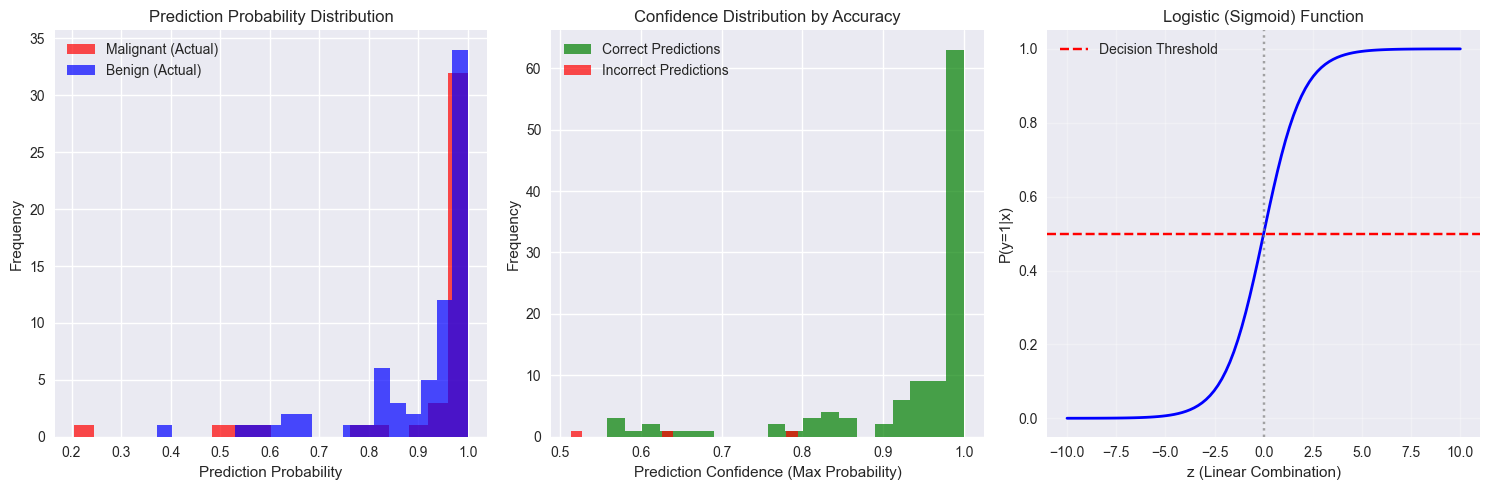

Average confidence for correct predictions: 0.9312
Average confidence for incorrect predictions: 0.6452
Minimum confidence: 0.5135
Maximum confidence: 1.0000


In [21]:
# Prediction Probability Analysis
plt.figure(figsize=(15, 5))

# Probability distribution for each class
plt.subplot(1, 3, 1)
malignant_probs = y_pred_proba_best[y_test == 0]
benign_probs = y_pred_proba_best[y_test == 1]

plt.hist(malignant_probs[:, 0], alpha=0.7, label='Malignant (Actual)', bins=20, color='red')
plt.hist(benign_probs[:, 1], alpha=0.7, label='Benign (Actual)', bins=20, color='blue')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Prediction Probability Distribution')
plt.legend()

# Confidence analysis
plt.subplot(1, 3, 2)
confidence = np.max(y_pred_proba_best, axis=1)
correct_predictions = (y_pred_best == y_test)

plt.hist(confidence[correct_predictions], alpha=0.7, label='Correct Predictions', bins=20, color='green')
plt.hist(confidence[~correct_predictions], alpha=0.7, label='Incorrect Predictions', bins=20, color='red')
plt.xlabel('Prediction Confidence (Max Probability)')
plt.ylabel('Frequency')
plt.title('Confidence Distribution by Accuracy')
plt.legend()

# Sigmoid function visualization
plt.subplot(1, 3, 3)
z = np.linspace(-10, 10, 100)
sigmoid = 1 / (1 + np.exp(-z))
plt.plot(z, sigmoid, 'b-', linewidth=2)
plt.axhline(y=0.5, color='r', linestyle='--', label='Decision Threshold')
plt.axvline(x=0, color='gray', linestyle=':', alpha=0.7)
plt.xlabel('z (Linear Combination)')
plt.ylabel('P(y=1|x)')
plt.title('Logistic (Sigmoid) Function')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average confidence for correct predictions: {confidence[correct_predictions].mean():.4f}")
print(f"Average confidence for incorrect predictions: {confidence[~correct_predictions].mean():.4f}")
print(f"Minimum confidence: {confidence.min():.4f}")
print(f"Maximum confidence: {confidence.max():.4f}")

## 8. Learning Curve Analysis

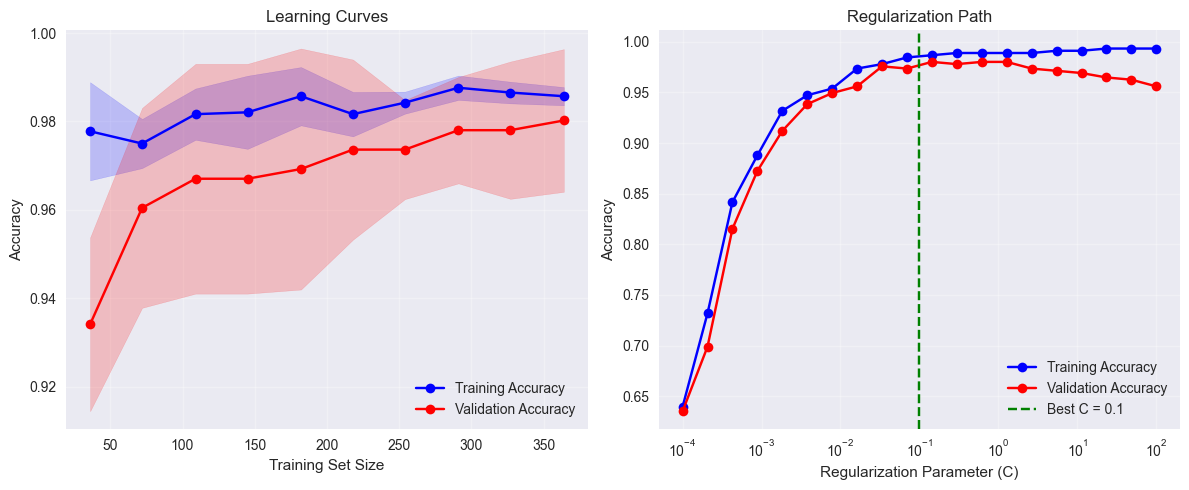

Best training size performance:
Training accuracy: 0.9857 (+/- 0.0021)
Validation accuracy: 0.9802 (+/- 0.0162)
Gap (overfitting): 0.0055


In [22]:
# Learning curve analysis
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_lr, X_train_scaled, y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='accuracy', n_jobs=-1
)

plt.figure(figsize=(12, 5))

# Learning curves
plt.subplot(1, 2, 1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Regularization path
plt.subplot(1, 2, 2)
C_range = np.logspace(-4, 2, 20)
train_accuracies = []
val_accuracies = []

for C in C_range:
    lr_temp = LogisticRegression(C=C, random_state=42, max_iter=1000)
    
    # Cross-validation for this C value
    cv_scores = cross_val_score(lr_temp, X_train_scaled, y_train, cv=5)
    val_accuracies.append(cv_scores.mean())
    
    # Training accuracy
    lr_temp.fit(X_train_scaled, y_train)
    train_acc = lr_temp.score(X_train_scaled, y_train)
    train_accuracies.append(train_acc)

plt.semilogx(C_range, train_accuracies, 'o-', color='blue', label='Training Accuracy')
plt.semilogx(C_range, val_accuracies, 'o-', color='red', label='Validation Accuracy')
plt.axvline(x=best_lr.C, color='green', linestyle='--', label=f'Best C = {best_lr.C}')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Accuracy')
plt.title('Regularization Path')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best training size performance:")
print(f"Training accuracy: {train_mean[-1]:.4f} (+/- {train_std[-1]:.4f})")
print(f"Validation accuracy: {val_mean[-1]:.4f} (+/- {val_std[-1]:.4f})")
print(f"Gap (overfitting): {train_mean[-1] - val_mean[-1]:.4f}")

## 9. Summary and Conclusions

In [23]:
# Final comprehensive summary
print("=== LOGISTIC REGRESSION ON BREAST CANCER DATASET ===")
print()
print("Dataset Summary:")
print(f"• Total samples: {len(X)}")
print(f"• Features: {len(data.feature_names)}")
print(f"• Classes: {data.target_names}")
print(f"• Class distribution: {np.bincount(y)} (Malignant: {np.bincount(y)[0]}, Benign: {np.bincount(y)[1]})")
print()

print("Model Performance:")
print(f"• Default Logistic Regression Accuracy: {accuracy:.4f}")
print(f"• Best (Tuned) Logistic Regression Accuracy: {accuracy_best:.4f}")
print(f"• ROC AUC Score: {roc_auc_best:.4f}")
print(f"• Cross-validation Score: {grid_search.best_score_:.4f}")
print(f"• Best Parameters: {grid_search.best_params_}")
print()

print("Model Interpretability:")
print("• Top 5 Most Important Features (by absolute coefficient):")
top_5_features = coef_df.tail(5)
for idx, row in top_5_features.iterrows():
    direction = "increases" if row['coefficient'] > 0 else "decreases"
    print(f"  - {row['feature']}: {row['coefficient']:.4f} ({direction} benign probability)")
print()

print("Key Insights:")
print("• Logistic regression achieved excellent performance on this binary classification task")
print("• Feature scaling was crucial for optimal performance")
print("• Regularization helped prevent overfitting")
print("• The model provides interpretable coefficients showing feature importance")
print("• High ROC AUC indicates excellent discrimination between classes")
print("• Learning curves show good generalization with minimal overfitting")
print("• The sigmoid function provides probabilistic predictions for clinical decision-making")
print()

print("Clinical Relevance:")
print("• High sensitivity and specificity make this suitable for medical screening")
print("• Probabilistic outputs allow for threshold adjustment based on clinical needs")
print("• Feature importance helps identify key diagnostic indicators")
print("• The linear nature of logistic regression makes it interpretable for medical professionals")

=== LOGISTIC REGRESSION ON BREAST CANCER DATASET ===

Dataset Summary:
• Total samples: 569
• Features: 30
• Classes: ['malignant' 'benign']
• Class distribution: [212 357] (Malignant: 212, Benign: 357)

Model Performance:
• Default Logistic Regression Accuracy: 0.9825
• Best (Tuned) Logistic Regression Accuracy: 0.9737
• ROC AUC Score: 0.9957
• Cross-validation Score: 0.9802
• Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}

Model Interpretability:
• Top 5 Most Important Features (by absolute coefficient):
  - worst area: -0.4623 (decreases benign probability)
  - worst perimeter: -0.4662 (decreases benign probability)
  - worst concave points: -0.5073 (decreases benign probability)
  - worst radius: -0.5094 (decreases benign probability)
  - worst texture: -0.5630 (decreases benign probability)

Key Insights:
• Logistic regression achieved excellent performance on this binary classification task
• Feature scaling was crucial for optimal performance
• Regularization hel